# SEP Pitch-angle distribution (PAD) and first-order anisotropies

This tool visualizes SEP pitch-angle distributions based on sectored measurements, and determines the first-order anisotropy of the SEP PAD including different methods. 

The tool includes pre-event background subtraction, for which the selected background interval is fitted (using potentially time-dependent models) and extrapolated into the future.

The steps of the tool are:
1. Make selections:

    a) Choose spacecraft and instrument from menu (radio buttons)
   
    b) Print available energy channels of the instrument
   
    c) Choose particle species, energy channel, and time averaging
   
    d) Choose time interval and load data. An overview plot shows.
2. Background analysis:
    
    a) choose and tweak background time interval (using the output plot) for background subtraction 
3. Determine 1st-order anisotropies
    
    a) Choose method to determine anisotropies.
   
    b) Change 'corr_window_end' under point 2 to change the interval for which the background-subtracted anisotropy is determined

In [1]:
from anisotropy import run_SEPevent, select_sc_inst, print_available_channels
from seppy.util import jupyterhub_data_path
import datetime as dt
import numpy as np
import os
import pandas as pd

### Saving figures

You can usually save a figure from the Notebook by right-clicking on it while holding down the ⇧ Shift key, then select "Save Image As..." (or similar).

### Select a local folder to save the downloaded data. If run on the project's JupyterHub server, it's set to a common data folder in the base directory. 

In [2]:
data_path = f"{os.getcwd()}{os.sep}data"
data_path = jupyterhub_data_path(data_path)

### Select Spacecraft & Instrument, particle species, and energy channel

In [3]:
spacecraft_instrument = select_sc_inst()

RadioButtons(description='Spacecraft & instrument:', layout=Layout(width='max-content'), options=('Solar Orbit…

In [16]:
print_available_channels(spacecraft_instrument.value)

Wind 3DP
Protons/Ions:
 channel                energy
       0     50.69 - 94.14 keV
       1    89.79 - 166.76 keV
       2   137.71 - 255.75 keV
       3   233.57 - 433.77 keV
       4   386.98 - 718.67 keV
       5   713.19 - 1324.5 keV
       6 1452.96 - 2698.36 keV
       7  3110.64 - 5776.9 keV
       8 4733.08 - 8790.01 keV

Electrons:
 channel              energy
       0     18.9 - 35.1 keV
       1    27.89 - 51.8 keV
       2   46.01 - 85.44 keV
       3  75.42 - 140.06 keV
       4 126.45 - 234.83 keV
       5 215.31 - 399.86 keV
       6 359.51 - 667.67 keV


# Select species, energy channel, and time averaging

In [11]:
species = "p"
channels = 2 
averaging = "2min"  # time averaging

# Set data loading and plotting window

Spacecraft: Solar Orbiter
Instrument: HET. Species: p. Channels: 2.
Cadence is 5.0 s.
Loading MAG...
Loading MAG...
RED = INWARD, negative polarity, [90, 270] degrees
BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees
Calculating PA coverage for HET...


  0%|          | 0/540 [00:00<?, ?it/s]

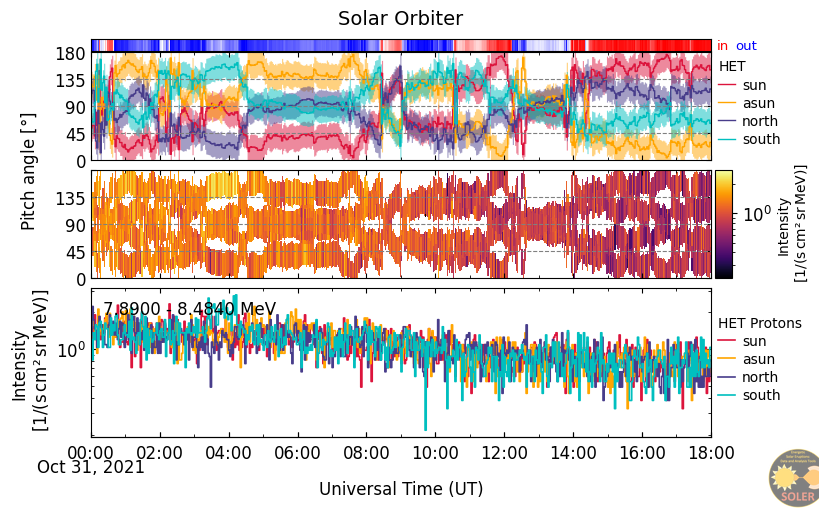

In [12]:
start_time = pd.to_datetime('2021-10-31 00:00:00')
end_time = pd.to_datetime('2021-10-31 18:00:00')

event = run_SEPevent(data_path, spacecraft_instrument.value, start_time, end_time, species, channels=channels, averaging=averaging)
fig, axes = event.overview_plot()

# Background analysis and subtraction
#### Choose a background window!
To determine the (potentially time-dependent) intensity background we fit both, a constant and an exponentially decaying model to the sector-averaged background intensity. The better fit is automatically chosen based on the reduded chi-squares. Then the model is extrapolated in time and subtracted from the measured intensities.

The parameter corr_window_end determines the end of the extrapolated background subtraction. The background-subtracted anisotropy is only determined until this time.

Background window start: 2021-10-31 23:00:00
Background window end: 2021-11-01 01:30:00
Background correction window end: 2021-11-01 04:30:00
Reduced chi-squared (constant model): 1.51
Reduced chi-squared (exponential model): 1.49


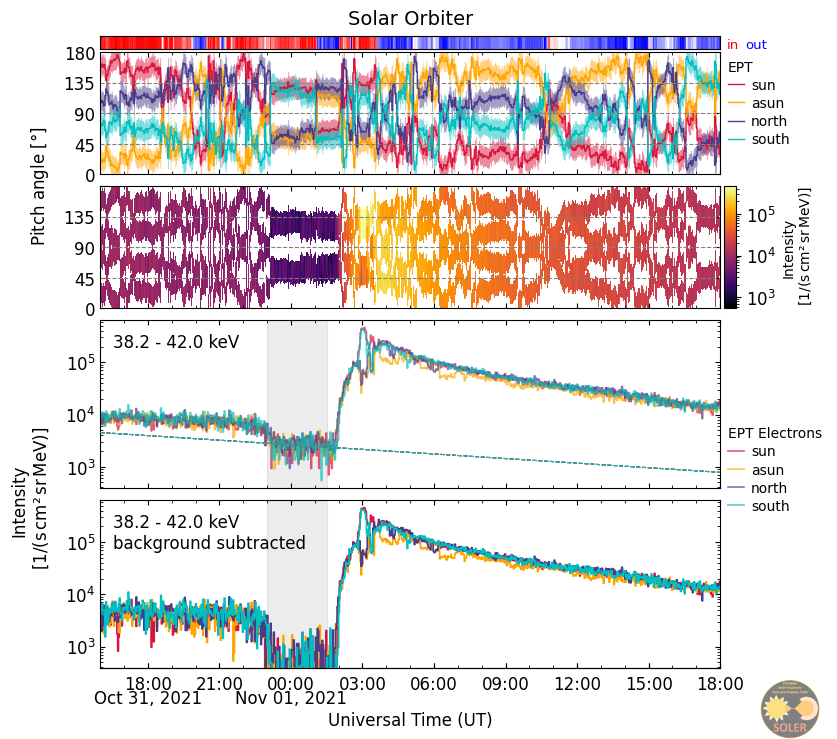

In [ ]:
# chose a background window. Setting these to None will set default window [start_time, start_time + 5 hours] 
bg_start = pd.to_datetime('2021-10-31 23:00:00')  # None
bg_end =  pd.to_datetime('2021-11-01 01:30:00')  # None

# chose an end time for the background subtraction:
# if None then background subraction stops 3 hours after the end of the background window (bg_end)
corr_window_end = None  # pd.to_datetime('2021-11-01 18:00:00') 

# resets background window and event.corr_window_end which is used to check that the background is not above the observations near the event start
event.set_background_window(bg_start, bg_end, corr_window_end)

# averaging (in minutes) used for the background analysis
bg_av_min = 10  

event.background_analysis_all(minutes=bg_av_min)
fig, axes = event.overview_plot_bgsub()

# Determine Anisotropies

Anisotropies are determined with and without background subtraction. Background-subtracted anisotropies are only calculated until 'corr_window_end' (see previous step).

### Choose the method for anisotropy calculation: 
- weighted-sum method (strongly suggested if only 4 viewing directions are available). The weighted-sum method is described in Brüdern et al. 2018, Central European Astrophysical Bulletin, 42, 2.

  
- weighted-sum method including bootstrapping: provides uncertainties for the anisotropy based on bootstrapping within intensity uncertainty ranges

- fit method: pitch-angle distributions are fitted with 2nd-order Legendre Polionomials to determine the anisotropy


Note that anisotropies during noisy low-intensity intervals (like right before the SEP event) cannot be trusted.

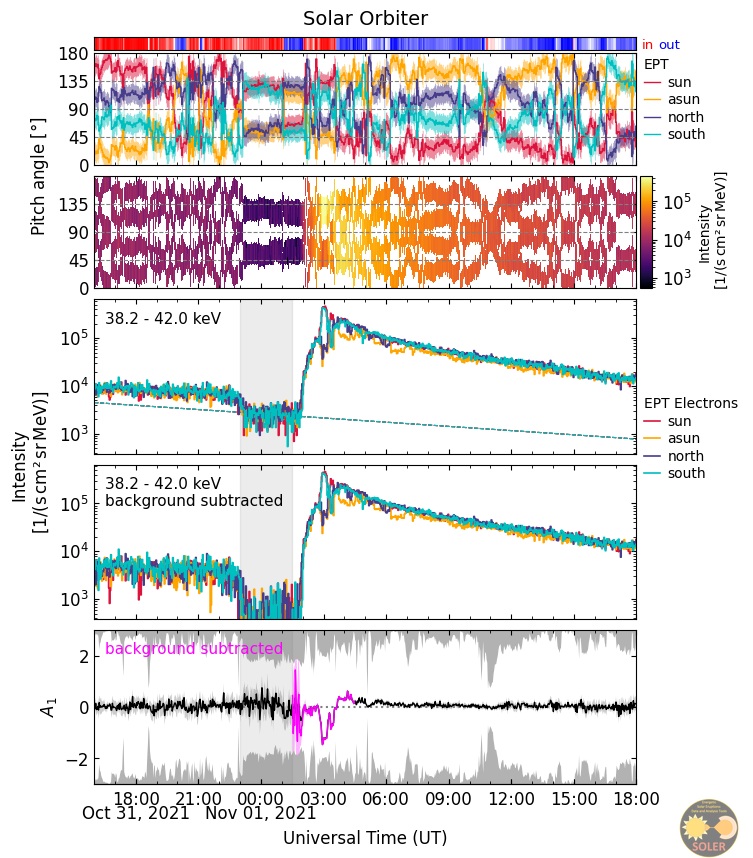

In [ ]:
ani_method = 'weighted_sum_bootstrap'  # 'weighted_sum', 'weighted_sum_bootstrap', or 'fit'; 
                                       #'weighted_sum_bootstrap' not available for Wind!

event.calculate_anisotropy(ani_method=ani_method)
fig, axes = event.anisotropy_plot(ani_method=ani_method)

### Plot explanations: 

#### Anisotropy panel:

First order anisotropies without (black) and with (magenta) background subtraction. 
Gray and magenta shades around the anisotropy lines show the anisotropy uncertainty based 2.5 and 95 percentiles resulting from the bootstrapping analysis based on counting rate statistics (and the background subtraction - magenta trace) (only shown when `ani_method='weighted_sum_bootstrap'`).

Gray shades at the top and bottom of the panel show anisotropy values that cannot be determined with the instrument's pitch-angle coverage at that time.

----------------------
#### Plarity bar at the top of the plot marks the magnetic field polarity:

RED = INWARD, negative polarity, [90, 270] degrees

BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees